In [5]:
NUM_SIMULATIONS = 3
for s in range(NUM_SIMULATIONS):
    print(f"SIMULATION NO : {s}", end="\r")
    # !python sgd.py --exp-name sgd{alp}_{s+1} --env-seed -1 --save True --track False --capture-video False --lr {lr}
    !python mujoco_experiments/sgd.py --exp-name SGD{s+1} --env-seed 1 --save True --track False --alpha 1_000_000 --normalize-returns True --num-updates 10


Iteration 0, Reward: 68.86063385009766, T1: 1.314, T2:0.504
Iteration 1, Reward: 71.12151336669922, T1: 1.119, T2:0.087
Iteration 2, Reward: 69.0545654296875, T1: 1.085, T2:0.06
Iteration 3, Reward: 67.47737121582031, T1: 1.014, T2:0.113
Iteration 4, Reward: 66.93287658691406, T1: 2.124, T2:0.12
Iteration 5, Reward: 69.09410858154297, T1: 2.054, T2:0.092
Iteration 6, Reward: 69.54064178466797, T1: 2.43, T2:0.139
Iteration 7, Reward: 69.71412658691406, T1: 2.508, T2:0.134
Iteration 8, Reward: 72.52001953125, T1: 2.331, T2:0.126
Iteration 9, Reward: 71.76045989990234, T1: 2.848, T2:0.155
Iteration 0, Reward: 68.86063385009766, T1: 1.3, T2:0.49
Iteration 1, Reward: 71.12151336669922, T1: 1.154, T2:0.059
Iteration 2, Reward: 69.0545654296875, T1: 1.145, T2:0.071
Iteration 3, Reward: 67.47737121582031, T1: 1.254, T2:0.107
Iteration 4, Reward: 66.93287658691406, T1: 2.075, T2:0.12
Iteration 5, Reward: 69.09410858154297, T1: 2.3, T2:0.125
Iteration 6, Reward: 69.54064178466797, T1: 2.47, T2:0

In [5]:
import torch

m, n = 2, 3

a = torch.randn(m, requires_grad=True)
b = torch.randn(n, requires_grad=True)

H = torch.randn(m, n, requires_grad=True)

In [6]:
a

tensor([0.2132, 1.2988], requires_grad=True)

In [7]:
b

tensor([-0.7994, -0.8992, -2.1464], requires_grad=True)

In [8]:
H

tensor([[ 0.5193,  0.3547,  0.7153],
        [ 0.1617, -1.0061,  1.1733]], requires_grad=True)

In [13]:
l2 = a @ H @ b
l2

tensor(-2.7477, grad_fn=<DotBackward0>)

In [91]:
# %%timeit
# grad1 = [torch.autograd.grad(l_, [a, b, c], retain_graph=True) for l_ in l2]

In [20]:
# %%timeit
grad2 = torch.autograd.grad(l2, [a], retain_graph=True)

In [21]:
# grad3 = torch.autograd.grad(l2.sum(), [a, b, c], retain_graph=True)

In [22]:
grad2

(tensor([-2.2693, -1.7430]),)

In [28]:
H @ b , a @ H

(tensor([-2.2693, -1.7430], grad_fn=<MvBackward0>),
 tensor([ 0.3208, -1.2311,  1.6764], grad_fn=<SqueezeBackward4>))

In [24]:
l1 = H @ b

In [31]:
grad1 = torch.autograd.grad(l1, [b], grad_outputs=b, retain_graph=True)

RuntimeError: Mismatch in shape: grad_output[0] has a shape of torch.Size([3]) and output[0] has a shape of torch.Size([2]).

In [30]:
grad1 # == a @ H

(tensor([-1.4603,  0.9487, -3.6682]),)

In [1]:
import os
import joblib
import numpy as np
import pandas as pd

def directory_to_dict(path):
    k = os.path.basename(path)
    if not os.path.isdir(path):
        # if path.lower().endswith('.csv'):
        #     return {k : pd.read_csv(path)}
        k = k.replace('.data', '')
        v = np.array(joblib.load(path))
        return {k : v}
    node_dict = {k: {}}
    for item in os.listdir(path):
        item_path = os.path.join(path, item)
        node_dict[k].update(directory_to_dict(item_path))
    return node_dict

# Path to `data` folder
DATA_PATH = './data_final'

# Convert the directory tree to a dictionary
data = directory_to_dict(DATA_PATH)
data['data'] = data[DATA_PATH.split('/')[-1]]

In [2]:
ALL_ENVS_DATA = {}

for algo in data['data']:
    all_envs_rets = {}
    all_envs_rews = {}
    all_envs_runs = {}
    
    for exp, v in data['data'][algo].items():
        # print(exp.split('__'))
        env_id, _, _, _ = tuple(exp.split('__'))
        all_envs_rets[env_id] = all_envs_rets.get(env_id, []) + [v['episodic_returns']]
        all_envs_rews[env_id] = all_envs_rews.get(env_id, []) + [v['episodic_rewards']]
        
    for env_id in all_envs_rets:
        all_envs_runs[env_id] = {'returns' : all_envs_rets[env_id]}
    
    for env_id in all_envs_rews:
        all_envs_runs[env_id].update({'rewards' : all_envs_rews[env_id]})

    ALL_ENVS_DATA[algo] = all_envs_runs

In [3]:
def calculate_moving_average_and_variance(time_series, window_size):
    """
    Calculate the moving average and moving variance of a time series.
    
    Parameters:
        time_series (numpy.ndarray): The input time series.
        window_size (int): The size of the moving window.
        
    Returns:
        pandas.DataFrame: A DataFrame containing the time series, moving average, and moving variance.
    """
    moving_average = pd.Series(time_series).rolling(window=window_size).mean()
    moving_std = pd.Series(time_series).rolling(window=window_size).std()
    
    df = pd.DataFrame({
        'time_series': time_series,
        'moving_average': moving_average,
        'moving_std': moving_std
    })
    
    return df.time_series.to_numpy(), df.moving_average.to_numpy(), df.moving_std.to_numpy()

In [4]:
import numpy as np
import matplotlib.pyplot as plt

GAP = 0.5
window_size = 100000 // 100

plotting_data = {}

for algo, dir_ in ALL_ENVS_DATA.items():
    for env_id, data in dir_.items():
        df_returns = pd.DataFrame(data['returns']).T
        df_rewards = pd.DataFrame(data['rewards']).T

        mean_returns = pd.Series(df_returns.mean(axis=1)).rolling(window=window_size).mean()
        std_returns = pd.Series(df_returns.std(axis=1)).rolling(window=window_size).mean()

        mean_rewards = pd.Series(df_rewards.mean(axis=1)).rolling(window=window_size).mean()
        std_rewards = pd.Series(df_rewards.std(axis=1)).rolling(window=window_size).mean()

        if env_id not in plotting_data:
            plotting_data[env_id] = {}

        plotting_data[env_id].update({algo : {
            'mean_rewards': mean_rewards,
            'mean_returns': mean_returns,
            'std_rewards': std_rewards,
            'std_returns': std_returns,
        }})

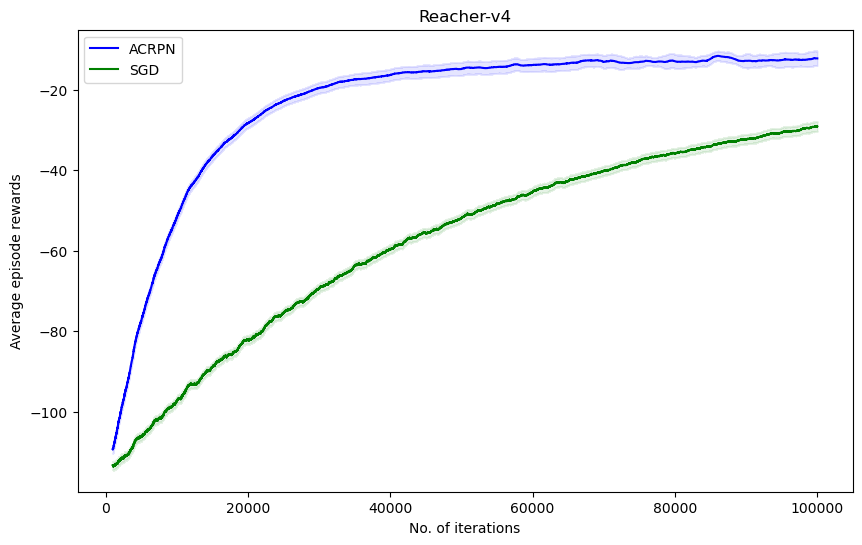

In [5]:
# plotting_data

color_map = {
    'sgd': 'green',
    'acrpn': 'blue',
    'sgd2': 'red',
}

for env_id, algo_data in plotting_data.items():

    # Create the plot
    plt.figure(figsize=(10, 6))
    
    for algo, data in algo_data.items():
        
#         if algo == 'acrpn':
#             continue
        
        mean_rewards = data['mean_rewards']
        std_rewards = data['std_rewards']
        
        # Plot the first time series
        plt.plot(np.arange(len(mean_rewards)), mean_rewards, label=algo.upper(), color=color_map[algo])
        
        # Fill between the two time series
        plt.fill_between(np.arange(len(mean_rewards)), mean_rewards+GAP*std_rewards, mean_rewards-GAP*std_rewards, alpha=0.1, color=color_map[algo])

    # Set labels and title
    plt.xlabel('No. of iterations')
    plt.ylabel('Average episode rewards')
    plt.title(env_id)
    plt.legend()
        

In [4]:
import torch
from torch import Tensor
from typing import List

@torch.jit.script
def qhm_update(params: List[Tensor],
            dp_list: List[Tensor],
            momentum_buffer_list: List[Tensor],
            lr: float,
            nu: float,
            weight_decay: float,
            weight_decay_type: str,
            momentum: float):

    for p, d_p, momentum_buffer in zip(params, dp_list, momentum_buffer_list):
        if weight_decay != 0:
            if weight_decay_type == "grad":
                d_p.add_(weight_decay, p)
            elif weight_decay_type == "direct":
                p.mul_(1.0 - lr * weight_decay)
            else:
                raise ValueError("Invalid weight decay type provided")

        momentum_buffer.mul_(momentum).add_(1.0 - momentum, d_p)

        p.data.add_(-lr * nu, momentum_buffer)
        p.data.add_(-lr * (1.0 - nu), d_p)